In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname  , filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/BloodPressureDataset/part_4.mat
/kaggle/input/BloodPressureDataset/part_9.mat
/kaggle/input/BloodPressureDataset/part_10.mat
/kaggle/input/BloodPressureDataset/part_11.mat
/kaggle/input/BloodPressureDataset/part_3.mat
/kaggle/input/BloodPressureDataset/part_1.mat
/kaggle/input/BloodPressureDataset/part_8.mat
/kaggle/input/BloodPressureDataset/part_5.mat
/kaggle/input/BloodPressureDataset/part_6.mat
/kaggle/input/BloodPressureDataset/part_7.mat
/kaggle/input/BloodPressureDataset/part_2.mat
/kaggle/input/BloodPressureDataset/part_12.mat
/kaggle/input/BloodPressureDataset/Samples/rec_235.csv
/kaggle/input/BloodPressureDataset/Samples/rec_389.csv
/kaggle/input/BloodPressureDataset/Samples/rec_397.csv
/kaggle/input/BloodPressureDataset/Samples/rec_395.csv
/kaggle/input/BloodPressureDataset/Samples/rec_338.csv
/kaggle/input/BloodPressureDataset/Samples/rec_11.csv
/kaggle/input/BloodPressureDataset/Samples/rec_431.csv
/kaggle/input/BloodPressureDataset/Samples/rec_454.csv
/kaggl

In [2]:
# importing libraries
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
os.listdir('/kaggle/input/BloodPressureDataset')

['part_4.mat',
 'part_9.mat',
 'part_10.mat',
 'Samples',
 'part_11.mat',
 'part_3.mat',
 'part_1.mat',
 'part_8.mat',
 'part_5.mat',
 'part_6.mat',
 'part_7.mat',
 'part_2.mat',
 'part_12.mat']

## Loading Data

In [3]:
sample_size = 125
ppg = []
ecg = []
bp = []
sbp = []
dbp = []

for i in range(1, 5):
    test_sample = scipy.io.loadmat(f'../input/BloodPressureDataset/part_{i}.mat')['p']

    for j in range(len(test_sample[0])):
        temp_mat = test_sample[0, j]
        temp_length = temp_mat.shape[1]
        
        for k in range((int)(temp_length/sample_size)):
            temp_ppg = temp_mat[0, k*sample_size:(k+1)*sample_size]
            temp_ecg = temp_mat[2, k*sample_size:(k+1)*sample_size]
            temp_bp = temp_mat[1, k*sample_size:(k+1)*sample_size]
            
            max_value = max(temp_bp)
            min_value = min(temp_bp)
            
            ppg.append(temp_ppg)
            ecg.append(temp_ecg)
            bp.append(temp_bp)
            sbp.append(max_value)
            dbp.append(min_value)

In [4]:
ppg, ecg, bp = np.array(ppg), np.array(ecg), np.array(bp)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)

In [5]:
signal =  np.zeros((ppg.shape[0] , 2, 125))
signal[:, 0, :] = ppg[: , :]
signal[:, 1, :] = ecg[: , :]

In [6]:
bp_combined = np.zeros((sbp.shape[0] , 2))
bp_combined[: , 0] = sbp[:, 0]
bp_combined[: , 1] = dbp[:, 0]

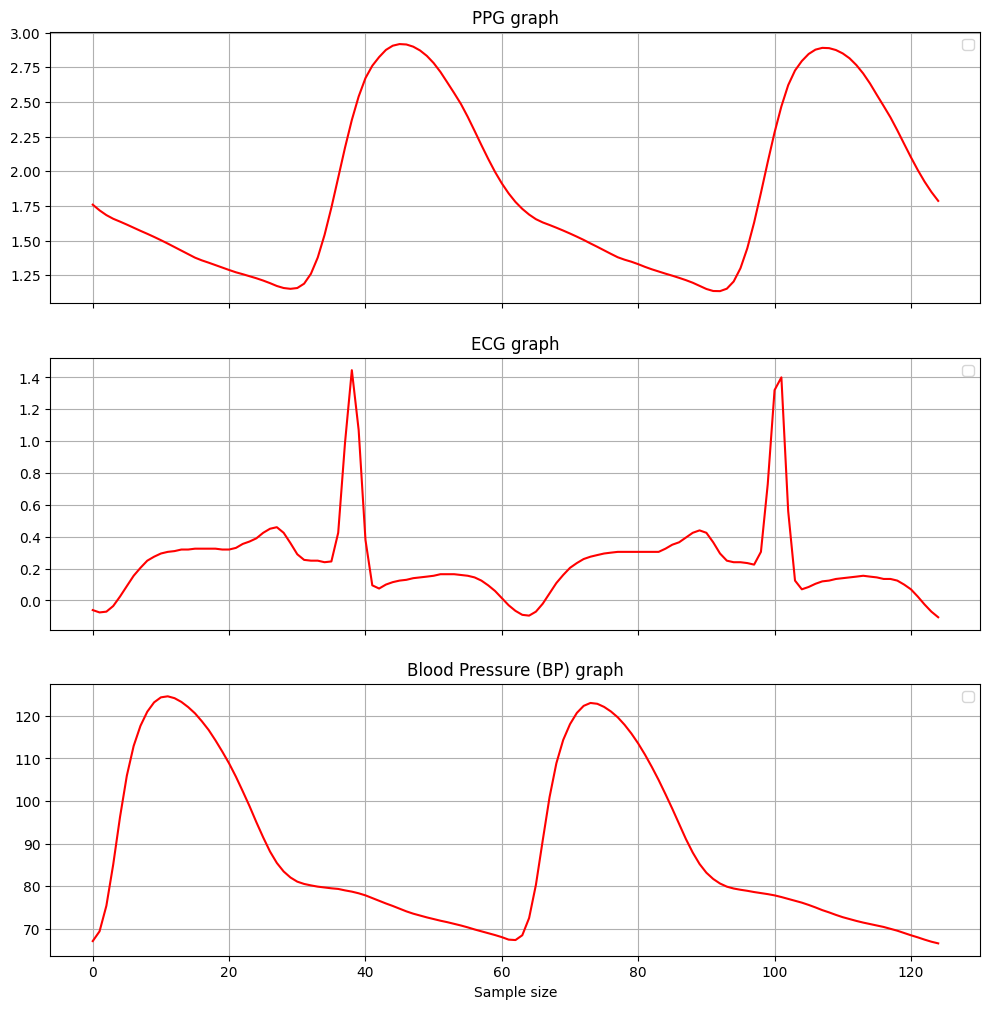

In [7]:
fig, ax = plt.subplots(3,1, figsize=(12,12), sharex=True)

ax[0].set_title('PPG graph')
ax[0].plot(ppg[0,:], 'r-')
ax[0].legend()
ax[0].grid(True)

ax[1].set_title('ECG graph')
ax[1].plot(ecg[0,:], 'r-')
ax[1].legend()
ax[1].grid(True)

ax[2].set_title('Blood Pressure (BP) graph')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[0,:], 'r-')
ax[2].legend()
ax[2].grid(True)


## Predicting Blood Pressure using Deep Learning

In [8]:
X_train, X_val, y_train, y_val = train_test_split(signal, bp_combined , test_size=0.30)

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.metrics import r2_score
from tensorflow.keras.losses import Huber

2024-08-20 13:49:09.032348: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-20 13:49:09.032471: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-20 13:49:09.181245: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [10]:
def huber_loss(y_true, y_pred, delta=1.0):
    error = y_true - y_pred
    is_small_error = tf.abs(error) <= delta
    small_error_loss = 0.5 * tf.square(error)
    large_error_loss = delta * (tf.abs(error) - 0.5 * delta)
    return tf.where(is_small_error, small_error_loss, large_error_loss)

In [11]:
def combined_loss(y_true, y_pred):
    huber_loss = tf.keras.losses.Huber(delta=1.0)
    mae_loss = tf.keras.losses.MeanAbsoluteError()
    return huber_loss(y_true, y_pred) + mae_loss(y_true, y_pred)

In [12]:
def Model(input_shape, activation, num_outputs):
    model = Sequential()

    # Flatten the input if it's not already a flat vector
    model.add(tf.keras.layers.Flatten(input_shape=input_shape))
    model.add(Dense(1024))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation(activation))
    model.add(Dropout(0.25))

    # Output layer for systolic and diastolic pressures
    model.add(Dense(num_outputs))
    model.add(Activation('linear'))

    # Compile the model
    model.compile(loss=combined_loss,
                  optimizer=optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(), RootMeanSquaredError()])
    return model

In [13]:
input_shape = (2, 125)
num_outputs = 2

# Instantiate the model
model = Model(input_shape=input_shape, activation='relu', num_outputs=num_outputs)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 250)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │       257,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 814,786 (3.11 MB)

 Trainable params: 814,786 (3.11 MB)

 Non-trainable params: 0 (0.00 B)

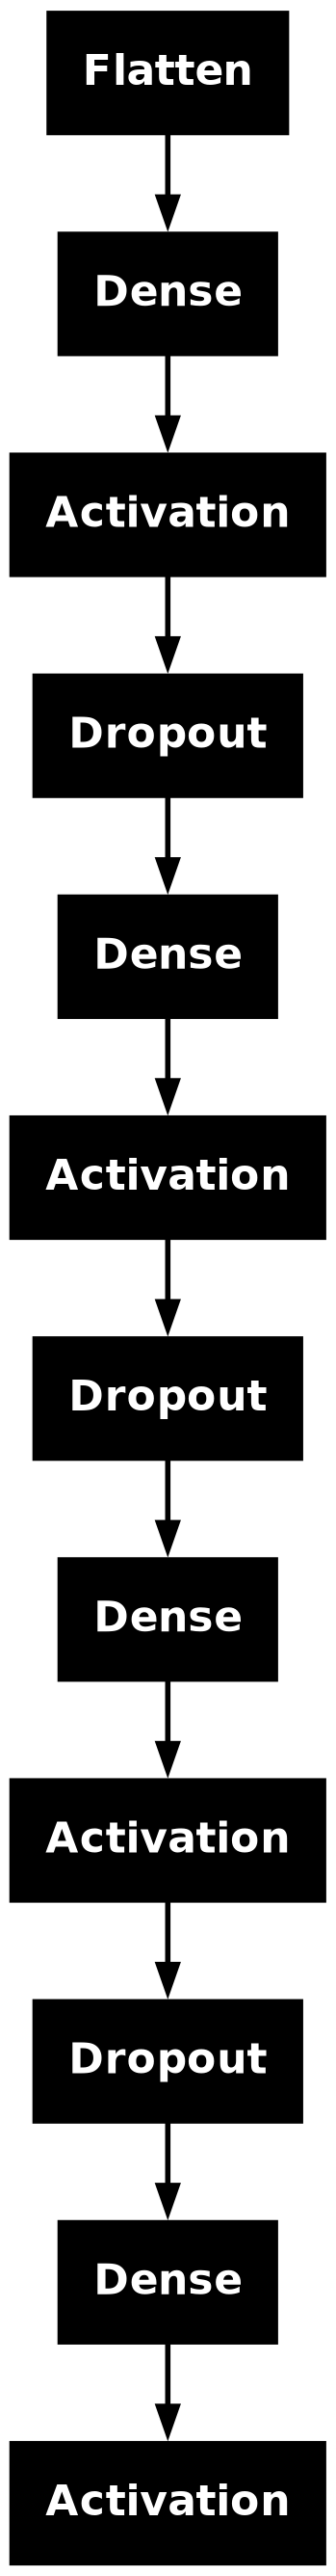

In [14]:
# Visualizing the model
tf.keras.utils.plot_model(model)

In [15]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Assuming X_train and y_train are your training data and labels
# Training the model with explicit validation data and early stopping
history = model.fit(X_train, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_split=0.25,
                    callbacks=[early_stopping],
                    verbose=1)

Epoch 1/50
  66/3723 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 96.6755 - mean_absolute_error: 48.5866 - root_mean_squared_error: 60.1659 

I0000 00:00:1724161767.921792      77 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1724161767.939930      77 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3723/3723 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - loss: 41.6459 - mean_absolute_error: 21.0699 - root_mean_squared_error: 28.6985 - val_loss: 25.0425 - val_mean_absolute_error: 12.7666 - val_root_mean_squared_error: 17.1139
Epoch 2/50
3723/3723 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 33.1306 - mean_absolute_error: 16.8116 - root_mean_squared_error: 22.4531 - val_loss: 24.9654 - val_mean_absolute_error: 12.7282 - val_root_mean_squared_error: 17.0528
Epoch 3/50
3723/3723 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 31.6485 - mean_absolute_error: 16.0703 - root_mean_squared_error: 21.4867 - val_loss: 25.9862 - val_mean_absolute_error: 13.2385 - val_root_mean_squared_error: 17.6929
Epoch 4/50
3723/3723 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 30.5066 - mean_absolute_error: 15.4992 - root_mean_squared_error: 20.7924 - val_loss: 26.3307 - val_mean_absolute_error: 13.4103 - val_root_mean_squared_error: 18.2529
Epoch 5/50
3723/3723 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 30.1867 - mean_absolute_

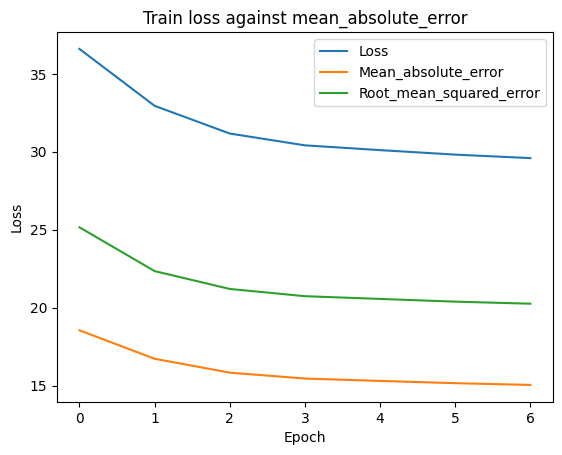

In [16]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['root_mean_squared_error'])
plt.legend(['Loss', 'Mean_absolute_error', 'Root_mean_squared_error' ])

In [17]:
y_pred = model.predict(X_val)
error = combined_loss(y_val, y_pred)
print(f'Neural Combined Loss: {error}')

8509/8509 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Neural Combined Loss: 24.99142837524414


In [18]:
sbp_true = y_val[:, 0]
sbp_pred = y_pred[:, 0]

dbp_true = y_val[:, 1]
dbp_pred = y_pred[:, 1]

# Create an array of sample indices (or sample numbers)
sample_indices = np.arange(len(y_val))

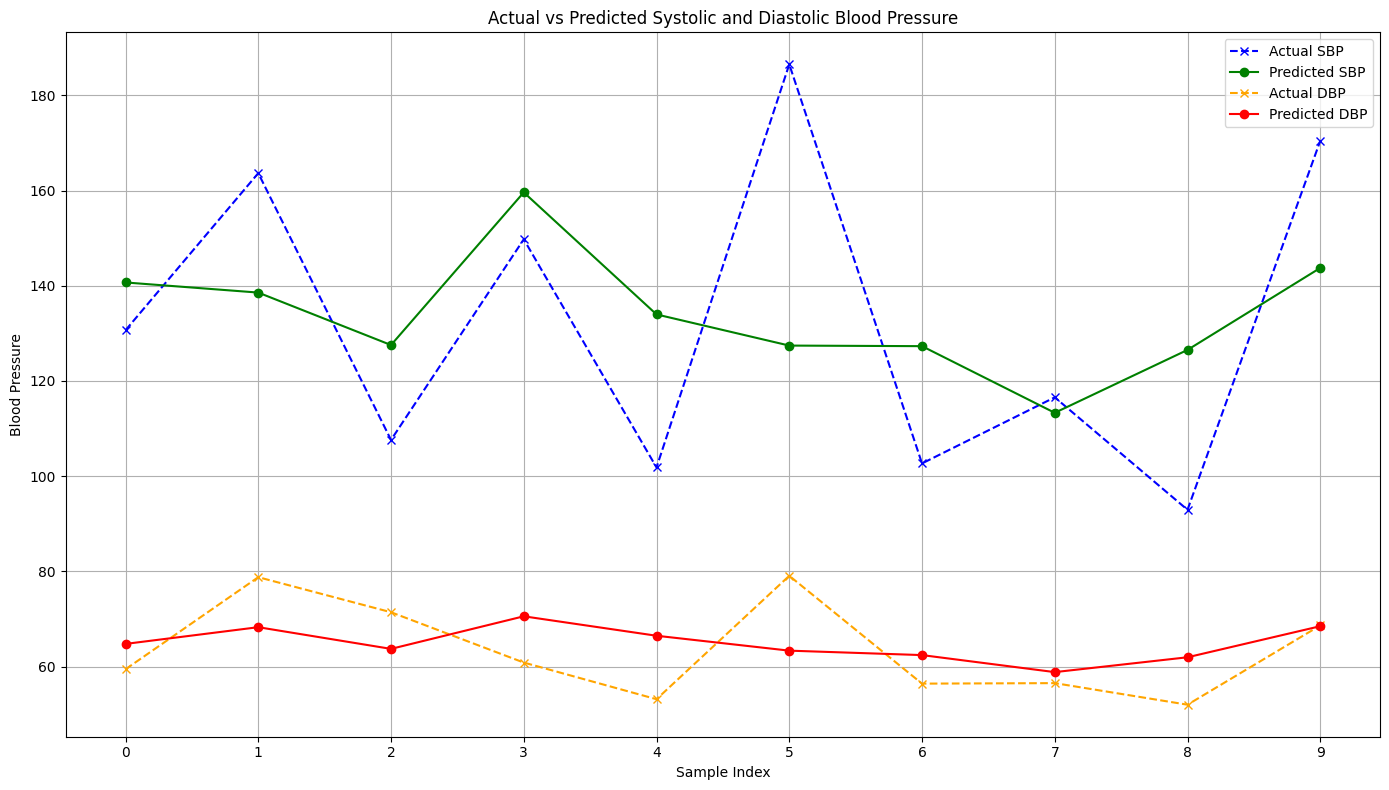

In [19]:
# Plotting SBP and DBP
plt.figure(figsize=(14, 8))

# Plotting Systolic Blood Pressure (SBP)
plt.plot(sample_indices[:10], sbp_true[:10], marker='x', linestyle='--', color='blue', label='Actual SBP')
plt.plot(sample_indices[:10], sbp_pred[:10], marker='o', linestyle='-', color='green', label='Predicted SBP')

# Plotting Diastolic Blood Pressure (DBP)
plt.plot(sample_indices[:10], dbp_true[:10], marker='x', linestyle='--', color='orange', label='Actual DBP')
plt.plot(sample_indices[:10], dbp_pred[:10], marker='o', linestyle='-', color='red', label='Predicted DBP')

# Adding labels and title
plt.xlabel('Sample Index')
plt.ylabel('Blood Pressure')
plt.title('Actual vs Predicted Systolic and Diastolic Blood Pressure')
plt.legend()
plt.grid(True)
plt.xticks(sample_indices[:10])  # Ensure all sample indices are displayed on x-axis

plt.tight_layout()
plt.show()


## ECG Feature Extraction

## Regression using extracted Features

## BP Calculation using formula